In [23]:
import pandas as pd
import numpy as np
import datetime
import re
import itertools
from konlpy.tag import Mecab
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

mec = Mecab("C:/mecab/mecab-ko-dic")
# model = joblib.load('./model/emotionModel.plk')
# tfv = joblib.load('./model/tfv.plk')
model = pickle.load(open('./model/emotionModel.plk', 'rb'))
tfv = pickle.load(open('./model/tfv.plk', 'rb'))

path = "./물금고등학교-익명의-숲_생활편/"

In [24]:
df_contents = pd.read_csv(path + 'contents.csv')

df_contents.dropna(inplace=True)
clean = re.compile(r'[^가-힣ㄱ-ㅎㅏ-ㅣ ]')
df_contents['content'] = df_contents['content'].apply(lambda x: clean.sub('', x))
df_contents['content'] = df_contents['content'].apply(lambda x: ''.join(ch for ch, _ in itertools.groupby(x)))
df_contents.drop_duplicates(subset=['content'], inplace=True)
df_contents.dropna(inplace=True)

df_contents['date'] = pd.to_datetime(df_contents['date'], format='%Y-%m-%d %H:%M')

In [25]:
weeks_all = [g for n, g in df_contents.set_index('date').groupby(pd.Grouper(freq='2W'))]

In [26]:
weeks = []
for week in weeks_all:
    week.drop(week[week['content'].apply(len) < 10].index, inplace=True)
    weeks.append(week.groupby('writer').agg({'content': ''.join}).reset_index())

In [27]:
def get_morph(df_contents):
    list_morph = []
    for idx, (writer, content) in df_contents[['writer', 'content']].iterrows():
        print('\r', idx + 1, "/", len(df_contents), sep="", end='')
        morph_all = mec.pos(content)
        morph_all = pd.DataFrame(morph_all, columns=['word', 'part'])

        morph = morph_all[(morph_all['part'] == 'NNG') | (morph_all['part'] == 'NNG')]['word'].to_list()
        
        list_morph.append(morph)
    return list_morph

In [28]:
for i, week in enumerate(weeks):
    week_morph = get_morph(week)
    print()
    week['morph'] = week_morph

22/22
37/37
30/30
22/22
11/11
11/11
4/4


In [29]:
for i, week in enumerate(weeks):
    week['emotion'] = week['morph'].apply(lambda x: model.best_estimator_.predict(tfv.transform(x)))

In [30]:
for week in weeks:
    week['ratio'] = round(week['emotion'].apply(sum) / (week['emotion'].apply(len) - week['emotion'].apply(sum)), 2)

In [34]:
col = ['writer']
for i in range(len(weeks)):
    col.append('ratio%d'%i)

df_change = pd.DataFrame(columns=col)
df_change.set_index('writer', inplace=True)
for i, week in enumerate(weeks):
    for idx, (writer, ratio) in week[['writer', 'ratio']].iterrows():
        if not writer in df_change.index:
            df_change = df_change.append(pd.Series(name=writer))
        df_change.loc[writer]['ratio%d'%i] = ratio
df_change.reset_index(inplace=True)

C:\Users\Heoshin\miniconda3\envs\exhibition\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.


In [36]:
col = ['writer']
for i in range(len(weeks)):
    col.append('ratio%d'%i)

df_change = pd.DataFrame()
for i, week in enumerate(weeks):
    for idx, (writer, ratio) in week[['writer', 'ratio']].iterrows():
        if not writer in df_change.columns:
            df_change[writer] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
        df_change[writer][i] = ratio
df_change

,강승원,공관위,김세은,김시윤,김은영,김조은,김준우,김태현,박성훈,박지원,...,정유진,홍수진,황인권,이유빈,이지영,유정민,정재훈,차지연,김민주,김가은
0,0.38,3.0,0.10,0.62,1.72,0.57,0.47,0.78,0.24,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.06,0.0,0.70,0.52,NaN,0.64,NaN,0.80,0.50,0.27,...,0.62,0.54,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.59,5.0,0.44,0.25,0.61,1.54,1.36,1.80,0.60,NaN,...,0.54,1.06,NaN,2.20,0.57,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.64,0.57,NaN,0.91,0.73,NaN,1.00,NaN,...,0.41,0.33,NaN,0.38,NaN,0.0,0.36,0.53,NaN,NaN
4,0.88,NaN,NaN,0.15,0.75,NaN,NaN,1.00,NaN,NaN,...,NaN,0.18,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN
5,0.39,NaN,NaN,0.20,NaN,0.59,NaN,NaN,NaN,NaN,...,NaN,0.83,NaN,NaN,NaN,NaN,NaN,NaN,0.84,NaN


In [11]:
df_change.drop(df_change.columns[df_change.apply(lambda x: x.notnull().sum() < 4)], axis=1, inplace=True)
df_change

,강승원,김세은,김시윤,김조은,김태현,박성훈,최선향,하예진,황보은별,박정은,홍수진
0,0.38,0.10,0.62,0.57,0.78,0.24,0.22,0.63,0.24,NaN,NaN
1,1.06,0.70,0.52,0.64,0.80,0.50,0.62,0.49,0.27,0.43,0.54
2,0.59,0.44,0.25,1.54,1.80,0.60,0.33,0.74,0.56,0.60,1.06
3,NaN,0.64,0.57,0.91,NaN,1.00,0.32,0.65,0.92,0.49,0.33
4,0.88,NaN,0.15,NaN,1.00,NaN,NaN,0.30,NaN,0.57,0.18
5,0.39,NaN,0.20,0.59,NaN,NaN,1.00,NaN,NaN,0.00,0.83


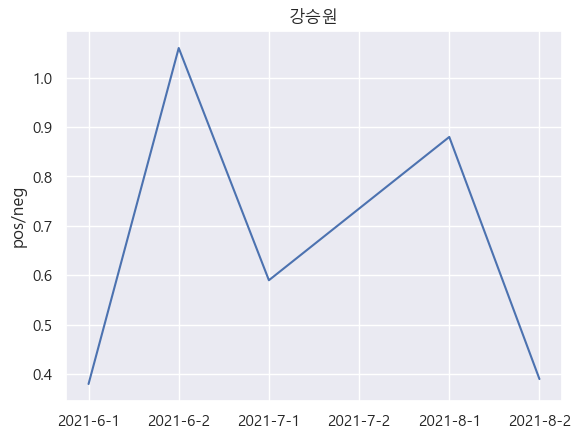

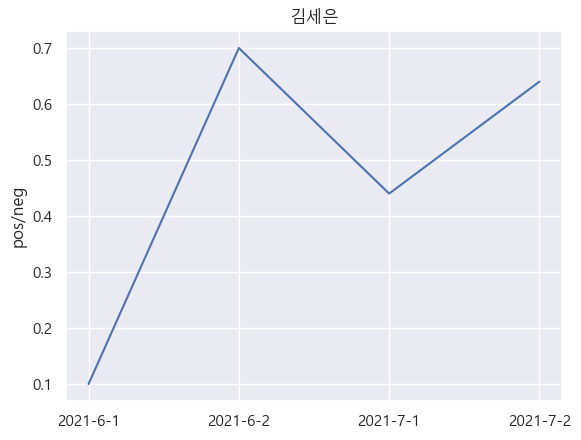

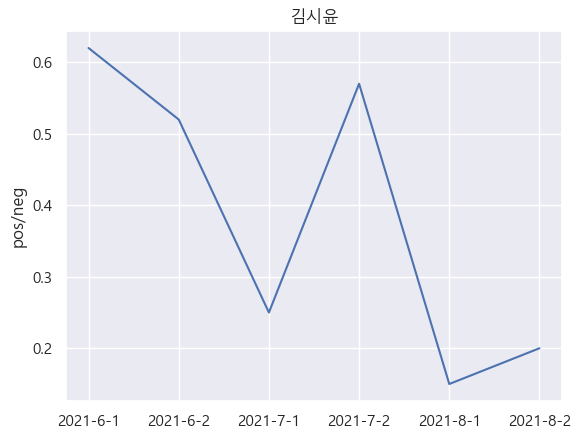

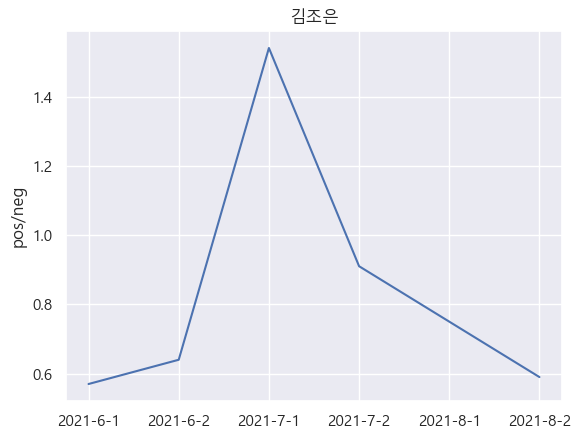

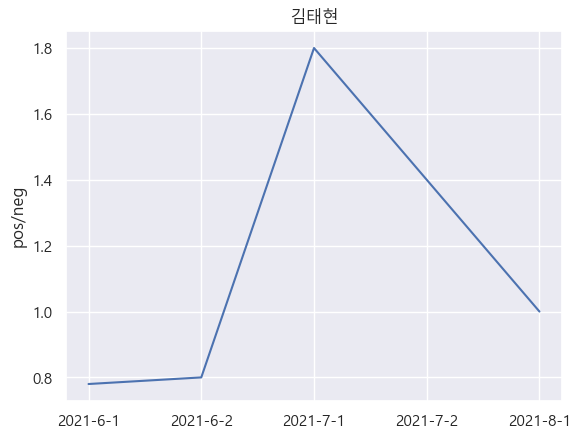

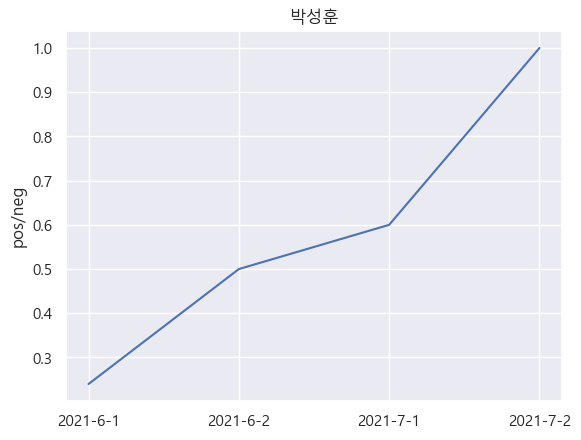

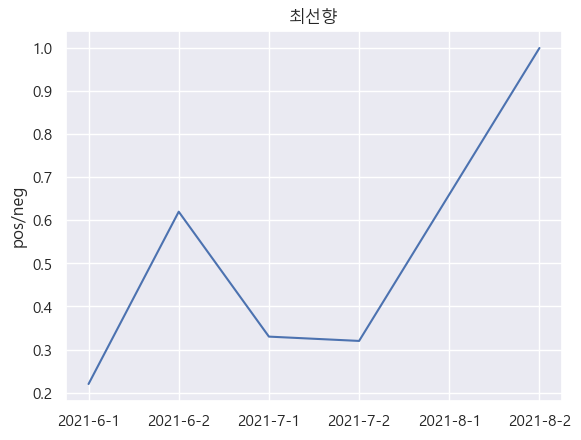

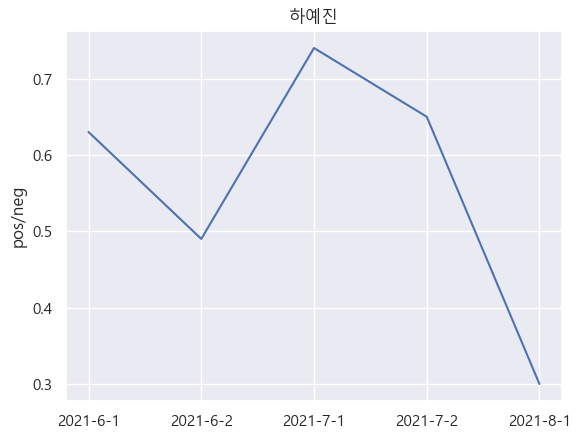

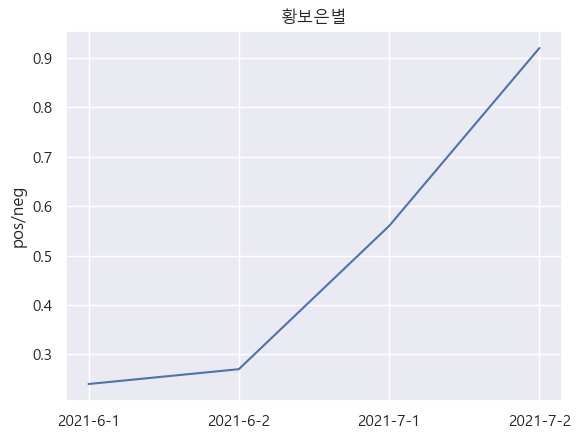

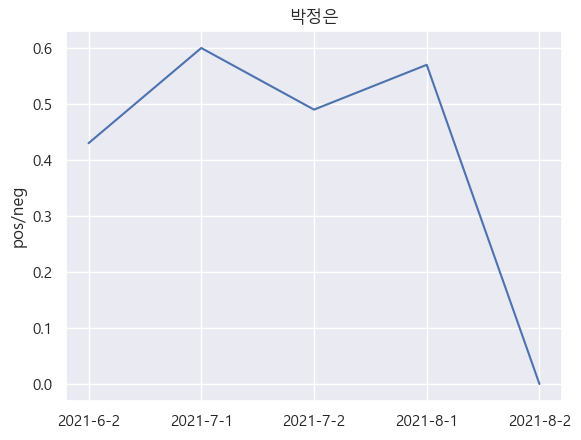

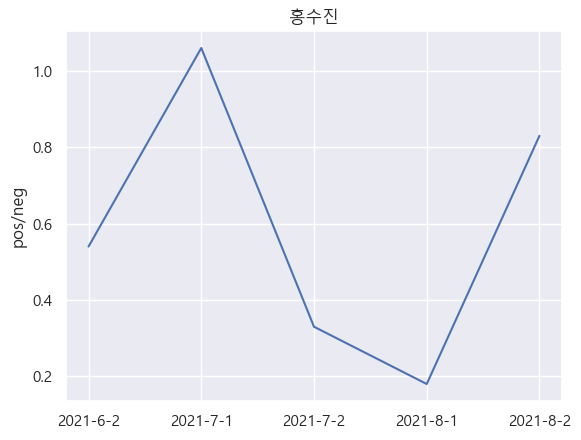

In [19]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')
df_change.index = ['2021-6-1', '2021-6-2', '2021-7-1', '2021-7-2', '2021-8-1', '2021-8-2']

for col in df_change:
        sns.lineplot(data=df_change[col])
        plt.title(col)
        plt.ylabel('pos/neg')
        plt.savefig(path + col + '.png')